# Week 4 `scipy` testing

This sets out the code needed in week 4 to replace `iminuit` with `scipy` for the first few execises using chi square/least squares.

# Section 4

## Example

In [1]:
# imports needed here but made earlier in orginal notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

In [2]:
# THIS IS UNCHANGED

# Note this is both the model we use to construct the data and the function we use to fit the data.
def line(x, m, c):
    return x*m + c


Ground truth values m=1.00, c=2.00


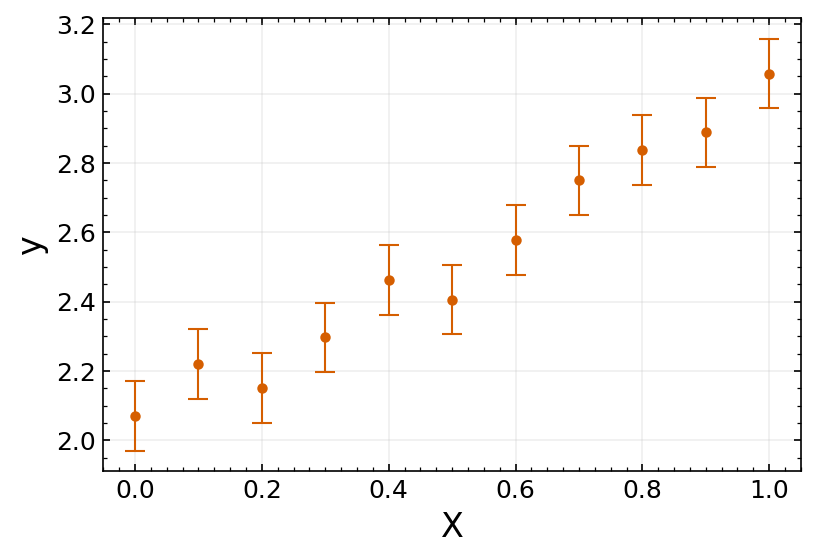

In [3]:
# THIS IS UNCHANGED

np.random.seed(1) # Set the random seed for consistency. Why not use 0?

# These are the "ground truth" values, the values used to create our data so hiding in our data
m_value=1.0
c_value=2.0
print("Ground truth values m={:.2f}, c={:.2f}".format(m_value,c_value))

n_points = 11 # 11 data points
data_x = np.linspace(0,1,n_points) # evenly spaced from 0.0 to 1.0 inclusive 
data_yerr = 0.1 # the standard deviation of the noise
data_y = line(data_x, m_value, c_value) + np.random.default_rng().normal(loc = 0, scale = data_yerr, size = n_points)

# Plot to show the data
fig = plt.figure(dpi = 150,figsize = (6,4))
ax = fig.add_subplot()
ax.errorbar(data_x, data_y, yerr = data_yerr,
            color='#D55E00',fmt='.',capsize = 5,ms = 8, elinewidth = 1,capthick = 1)
ax.set_xlabel('X',fontsize = 16)
ax.set_ylabel('y',fontsize = 16)
# ax.xaxis.set_major_locator()
ax.xaxis.set_minor_locator(MultipleLocator(0.025))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(axis='both',labelsize = 12, direction='in',top = True, right = True, which='both')
ax.grid('xkcd:dark blue',alpha = 0.2)

In [4]:
# scipy has the chi square (least squares) cost function built in.
# See https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
from scipy.optimize import curve_fit

# Make some reasonable estimate of parameters to start fitting.
# Could do by eye or I just use a couple of points to do this
m_est = (data_y[-1]-data_y[0] ) / (data_x[-1]-data_x[0] )
c_est = data_y[0] - m_est * data_x[0] 
print("Estimated values m={:.2f}, c={:.2f}".format(m_est,c_est))

# Starting values for parameters given in SAME order as function, here "line"
initial_value_list = [m_est,c_est]

# If the y errors are constant as here then the value makes 
# no difference to the fit but you can still include it and
# it alters the the optimal value of the chi square cost function.
# Normally sigma should be an array.
sigma_list = [data_yerr]*len(data_x) 
popt, pcov = curve_fit(line, data_x, data_y, 
                       p0 = initial_value_list,
                      sigma = sigma_list )

Estimated values m=0.99, c=2.07


In [5]:
# The first object "curve_fit" returns, here  "popt" is
# a list of parameter values in the order given in the function 
# fitted, here "line"
print (popt)
print("Best fit values m={:.2f}, c={:.2f}".format(popt[0],popt[1]))


[0.97225466 2.03398432]
Best fit values m=0.97, c=2.03


In [6]:
# The second object "curve_fit" returns, here  "pcov" is
# a 2-D array, the covariance matrix, tyhe parameters linked to each 
# row and column are arranged in the same order as given 
# in the function  fitted, here "line"
print(pcov)



[[ 0.00376051 -0.00188026]
 [-0.00188026  0.00131618]]


In [7]:
# The one-sigma error in each parameter is simply
# the square root on the relevant diagonal element
perr = np.sqrt(np.diag(pcov))
print(perr)
print("Best fit values m={:.2f} +/- {:.2f}, c={:.2f} +/- {:.2f} ".format(popt[0],perr[0],popt[1],perr[1]))


[0.06132302 0.03627919]
Best fit values m=0.97 +/- 0.06, c=2.03 +/- 0.04 


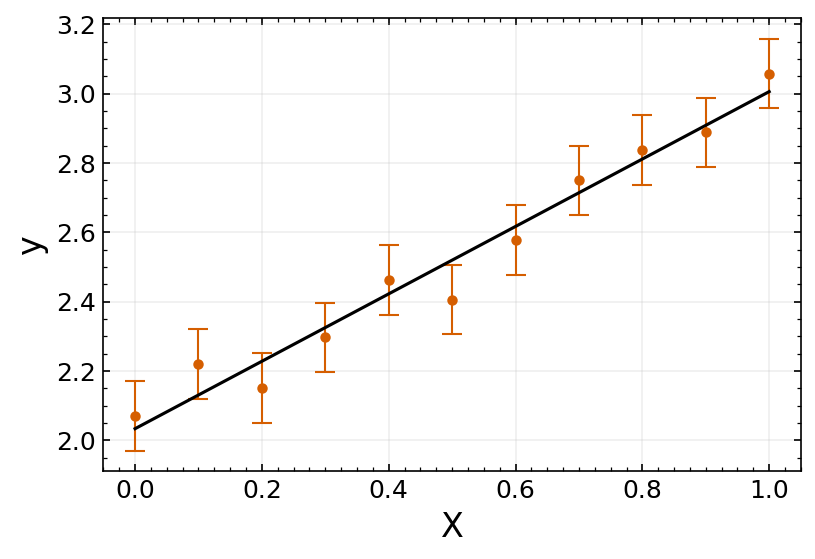

In [8]:
# Visualise the fit
fig = plt.figure(dpi = 150,figsize = (6,4))
ax = fig.add_subplot()
ax.errorbar(data_x, data_y, yerr = data_yerr,
            color='#D55E00',fmt='.',capsize = 5,ms = 8, elinewidth = 1,capthick = 1)

# for the best fit, note how we can use the * operator to upack the optimal
# parameter values as they appear in the coorect order.
fit_x_values = np.linspace(0,1,100)
fit_y_values = line(fit_x_values,*popt)
ax.plot( fit_x_values, fit_y_values, color='black')

# Now add other bits
ax.set_xlabel('X',fontsize = 16)
ax.set_ylabel('y',fontsize = 16)
ax.xaxis.set_minor_locator(MultipleLocator(0.025))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))

ax.tick_params(axis='both',labelsize = 12, direction='in',top = True, right = True, which='both')
ax.grid('xkcd:dark blue',alpha = 0.2)

You can now use the data for the optimal fitted values and the data to calculate the chi square or any other goodness of fit measure exactl;y as we did in week 3. 

However, the scipy `curve_fit` is optimising the chi square goodness of fit measure to find the best parameter values. So it should not be a surpise to find we already have that value if we ask for it using `full_output = True`
but we need to allow for three additional outputs.

For the chi square values the one we need is the array `infodict['fvec']` as these are the pull values at each data point for the optimal fit so the sum of the pull values squared gives you chi square.

In [9]:
popt, pcov, infodict, mesg, ier = curve_fit(line, data_x, data_y, 
                                 p0 = initial_value_list,
                                 sigma = sigma_list,
                                 full_output = True)
print("Output message:- "+mesg)
print("Output integer flag, values 1,2,3, and 4 indicate success:- "+str(ier))
print(infodict.keys())

print(infodict['fvec'])

Output message:- The relative error between two consecutive iterates is at most 0.000000
Output integer flag, values 1,2,3, and 4 indicate success:- 2
dict_keys(['fvec', 'nfev', 'fjac', 'ipvt', 'qtf'])
[-0.36261401 -0.89082226  0.77094851  0.28274374 -0.39689013  1.14319318
  0.38891013 -0.35644802 -0.26416369  0.20415171 -0.51900917]


In [10]:
chi2_value = sum(infodict['fvec']**2)
print("chi square value is {:.2f}".format(chi2_value))

ndof = len(data_x) - len(popt) # two parameters used in fit 
print("Number of data points is {:d} with {:d} fitted parameters".format(len(data_x),len(popt)))
print("So number of degrees of freedom is {:d}".format(ndof))

reduced_chi2_value = chi2_value/ndof
print("Then reduced chi square value is {:.2f}".format(reduced_chi2_value))

# Use the chi square distribution (not the test statistic) to get p-value, see week 3
# Use chi2.sf(value,ndof) (sf = "survival function") = 1 - chi2.cdf(value,ndof)
from scipy.stats import chi2 
p_value = chi2.sf(chi2_value, ndof)
print("and associated p- value is {:.2f}".format(p_value))

# I found chi^2 = 13.02 and p=0.16 for  random seed =0
# I found chi^2 =  8.08 and p=0.53 for  random seed =1

chi square value is 3.72
Number of data points is 11 with 2 fitted parameters
So number of degrees of freedom is 9
Then reduced chi square value is 0.41
and associated p- value is 0.93


It is interesting to note that the first time I ran this with random seed 0  I found $\chi^2 = 13.02$ and $p=0.16$ which seemed a little low.  When I looked at the fit and the residuals (see next plot) they all looked fine.

As this is a purely theoretical example, I could run the "experiment" a second time using a different random seed, 1, to get "new" but similar data. Then I found $\chi^2 =  8.08$ and $p=0.53$ which look much better and are the sort of numbers I expected.

It just goes to show that with my first seed I got a value for my goodness of fit measure, the $\chi^2$ value, which would only be exceed by the expected random variation in results about 16% of the time (the p-value). Still that is only one in five attempts so if we tried ten different random seeds we might expect this kind of "high" chi square value about twice. Thats very acceptable in most cases.  

Since we have the pulls, let us plot them quickly. Remember the errors in a pull is instrinsically $\sigma=1$ for all pulls so I feel there is no need to add explicit error bars here (they are all the same size).

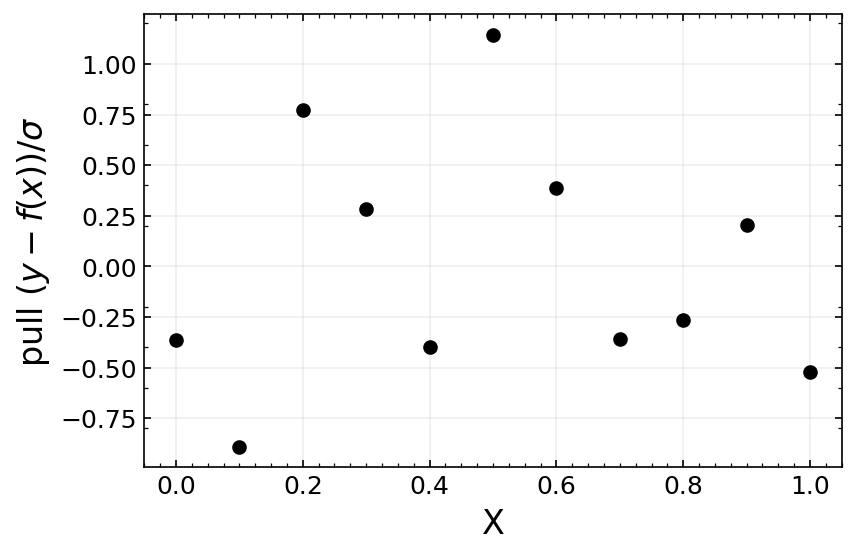

In [11]:
# Visualise the fit by showing the pull values, the resduals here
# Note no need to show errors, one sigma deviation is always +/- 1 
fig = plt.figure(dpi = 150,figsize = (6,4))
ax = fig.add_subplot()
pull_values = infodict['fvec']
ax.plot(data_x, pull_values, 'o', color='black')

# Now add other bits
ax.set_xlabel('X',fontsize = 16)
ax.set_ylabel(r'pull $(y-f(x))/\sigma$',fontsize = 16)
ax.xaxis.set_minor_locator(MultipleLocator(0.025))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))

ax.tick_params(axis='both',labelsize = 12, direction='in',top = True, right = True, which='both')
ax.grid('xkcd:dark blue',alpha = 0.2)

<div style="background-color:#C2F5DD">
    
### Exercise 1

Fit the data set in the following code cell with different orders of polynomial. Describe qualitatively how the fit changes, and how well the fit describes the data as you increase the order of the polynomial. When does the fit show signs of overfitting? Remember the following points:

* Define your cost function
* Define your Minuit object
* Run the optimisation
* Plot the data and your fit

Use the `line_np` function we have previously defined as your model. You can change the order of polynomial by passing more parameters as `pars` to this function. For instance if you call `line_np(X, (5, 5))` you will be testing a linear model, but if you call `line_np(X, (5, 5, 5, 5))` you will be testing a fit to a cubic, a polynomial of order 3.

In [12]:
# DATA for exercise 1, week 4
x_values = [-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

y_measured = [343.39452514, 251.31914561, 186.7806368, 121.30027965, 45.23336652, 
              23.49470302, 18.46581766, 6.58329486, 1.98522328, -6.74799454, 
              -7.55489379, -29.55544088, -31.32898172, -36.27525348, -25.23860169, 
              -1.09156819, 52.32898397, 225.38126087, 460.67437131]

y_err = [141.312, 86.205, 49.632, 26.877, 13.872, 
         7.197, 4.08, 2.397, 0.672, 1.923, 5.568, 
         9.795, 13.488, 14.883, 11.568, 0.483, 
         22.08, 60.477, 119.712]
    


In [13]:
# Note the use of *par, 
# a standard way to pass an arbitrary number of parameters to a python routine
def line_np(x, *par):
    """
    Input
    -----
    x = a 1D array of values
    *par = a list of comma separated values of any length
    
    Return
    ------
    An array of polynomial values equal to
    par[0]*x**(N-1) + par[1]*x**(N-2) + ... + par[N-2]*x + par[N-1]
    where par[n] is the n-th extra parameter
    
    """
    return np.polyval(par, x)  # for len(par) == 2, this is a line

# example/check, 0*x^3 + 1.0 x^2 + 2.0x+3.0 = 1+2+3 =6 for x=1.0
print(line_np(1.0, 0.0, 1.0 , 2.0, 3.0))


6.0


In [14]:
# I'm going to start with using the original straight line function "line" 
# Trying to fit straight line, y = m x + c
# The errors are small around values at indices 8 and 9 so try those
m_est = (y_measured[9]-y_measured[8])/(x_values[9]-x_values[8])
c_est = y_measured[8] - m_est*x_values[8]
print("For line y = mx + c fit, estimate m={:f}, c={:f}".format(m_est,c_est))

# use some dummy variables "_" for bits we won't use
popt_ex1_p2, pcov_ex1_p2, infodict_ex1_p2, _, _ = curve_fit(line, 
                                x_values, y_measured, 
                                 p0 = [m_est,c_est],
                                 sigma = y_err,
                                 full_output = True)



For line y = mx + c fit, estimate m=-8.733218, c=19.451659


In [15]:
# The first object "curve_fit" returns, here  "popt" is
# a list of parameter values in the order given in the function 
# fitted, here "line"
print (popt)
print("For line y = mx + c, best fit values: m={:.2f}, c={:.2f}".format(popt[0],popt[1]))

# The one-sigma error in each parameter is simply
# the square root on the relevant diagonal element
perr = np.sqrt(np.diag(pcov))
print(perr)
print("For line y = mx + c, best fit values: m={:.2f} +/- {:.2f}, c={:.2f} +/- {:.2f} ".format(popt[0],perr[0],popt[1],perr[1]))


[0.97225466 2.03398432]
For line y = mx + c, best fit values: m=0.97, c=2.03
[0.06132302 0.03627919]
For line y = mx + c, best fit values: m=0.97 +/- 0.06, c=2.03 +/- 0.04 


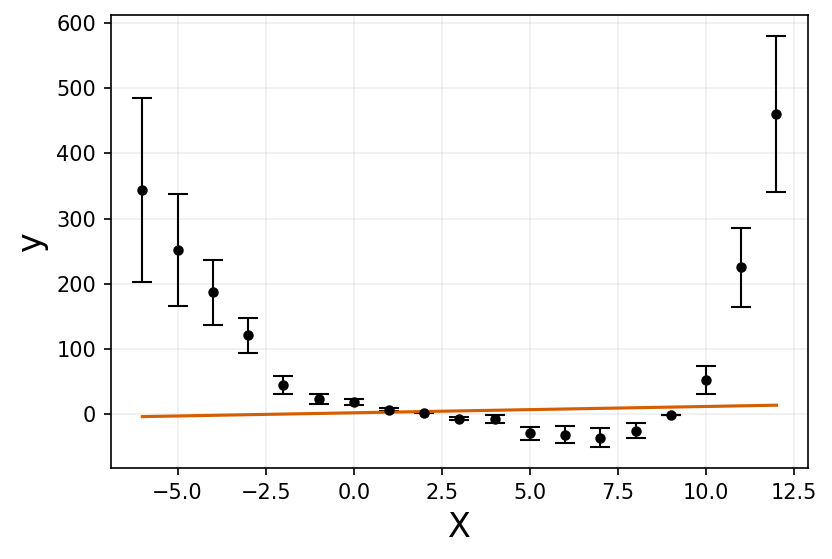

In [16]:
# Plot data and pure line fit

fig = plt.figure(dpi = 150,figsize = (6,4))
ax = fig.add_subplot()
ax.errorbar(x_values, y_measured, yerr = y_err,
            color='#000000',fmt='.',capsize = 5,ms = 8, elinewidth = 1,capthick = 1)
x_min = min(x_values)
x_max = max(x_values)
fit_x_values = np.linspace(x_min,x_max,100)
fit_y_values = line(fit_x_values,*popt)
ax.plot( fit_x_values, fit_y_values, color='#D55E00')

ax.set_xlabel('X',fontsize = 16)
ax.set_ylabel('y',fontsize = 16)
# ax.xaxis.set_major_locator()
#ax.xaxis.set_minor_locator(MultipleLocator(0.025))
#ax.yaxis.set_minor_locator(MultipleLocator(0.05))
#ax.tick_params(axis='both',labelsize = 12, direction='in',top = True, right = True, which='both')
ax.grid('xkcd:dark blue',alpha = 0.2)

Hmmm. The plots shows a linear fit is terrible. I should have looked at the data before I tried anything else.

Fitting order 4 polynomial
Fitting order 5 polynomial
Fitting order 6 polynomial
Fitting order 8 polynomial


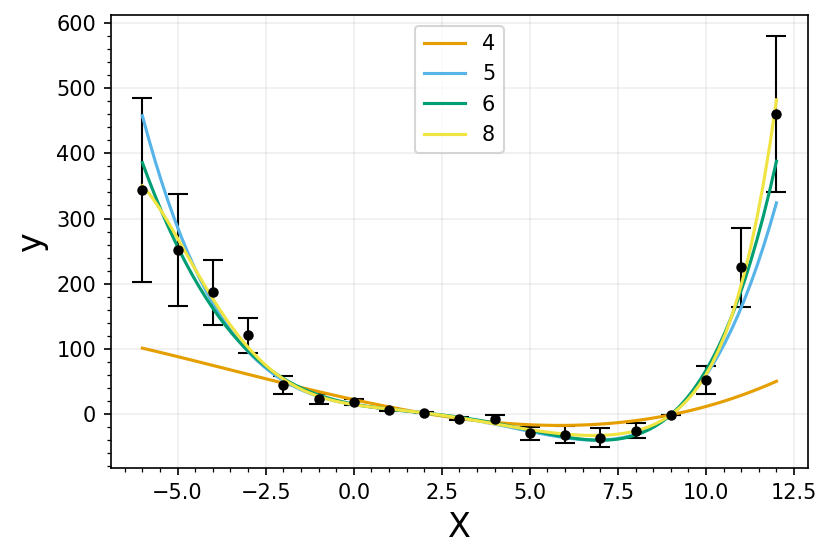

In [17]:
""" This is fancier than you need. 
You could have tried one cell, changing the order of the polynomial 
until you found what works. Then you could just copy and paste to show
three or four examples. Much easier and quicker than what I am doing here.
"""
N_list=[4,5,6,8] # order of polynomial, maximum power is x^N where N=N_list[i]

cf_list = [] # list of the cf = curve_fit objects as dictionary with keys
             # 'popt', 'perr' and 'infodict'
for N in N_list:
    print ("Fitting order {:d} polynomial".format(N))
    
    # First set the initial parameter values to be [0,0, ..., m_est,c_est]
    # Length of this initial parameter value list sets the order of polynomial fitted
    initial_argument_list = [0]*N # Set all coefficient values of polynomial to be zero 
    initial_argument_list[-1] = c_est # set last one equal to c estimate
    initial_argument_list[-2] = m_est # set second last one equal to c estimate
    
    # Now curve fit
    popt_ex1_pn, pcov_ex1_pn, infodict_ex1_pn, _, _ = curve_fit(line_np, 
                                x_values, y_measured, 
                                 p0 = initial_argument_list,
                                 sigma = y_err,
                                 full_output = True)

    cf_list.append( {'popt':popt_ex1_pn, 
                     'pcov':popt_ex1_pn, 
                     'infodict':infodict_ex1_pn} )
    
# Plot data and fit

fig = plt.figure(dpi = 150,figsize = (6,4))
ax = fig.add_subplot()
ax.errorbar(x_values, y_measured, yerr = y_err,
            color='#000000',fmt='.',capsize = 5,ms = 8, elinewidth = 1,capthick = 1)

# X Values to use when showing fitted curve
x_min = min(x_values)
x_max = max(x_values)
fit_x_values = np.linspace(x_min,x_max,100)

# Colours from Okabe_Ito list in appendix of week 1
Okabe_Ito =  ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#000000"]

# for each fit, plot a line
for fit_number in range(len(cf_list)):
    cf_output = cf_list[fit_number]
    fit_y_values = line_np(fit_x_values, *cf_output['popt'] )
    ax.plot( fit_x_values, fit_y_values, 
            color=Okabe_Ito[fit_number], 
            label=str(N_list[fit_number]) )

# labels etc
ax.set_xlabel('X',fontsize = 16)
ax.set_ylabel('y',fontsize = 16)

ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(100))

ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(20))

#ax.tick_params(axis='both',labelsize = 12, direction='in',top = True, right = True, which='both')
ax.grid('xkcd:dark blue',alpha = 0.2)    

plt.legend(loc='best')